In [1]:
import os
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'

import psutil

# Get the current process
# p = psutil.Process(os.getpid())

# # Set the process to run only on the first CPU core
# p.cpu_affinity([5])

In [2]:
import os
import gc
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import anndata as ad
import numpy as np
import yaml
import sys
import h5py
import logging
import scanpy as sc
from os.path import join
import scipy.sparse as sps
from sklearn.cluster import KMeans

import scglue

import warnings
def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

from sklearn.metrics import adjusted_rand_score

def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
def search_louvain(ad, use_rep, n_neighbors=15, n_clusters=5):
    sc.pp.neighbors(ad, n_neighbors=n_neighbors, use_rep=use_rep)
    rs = np.arange(0.1, 1.0, 0.1)
    n_cs = []
    for r in rs:
        sc.tl.louvain(ad, resolution=r, key_added=f'r={r}')
        n_cs.append(ad.obs[f'r={r}'].nunique())
    n_cs = np.array(n_cs)
    if (n_cs==n_clusters).sum() >= 1:
        ri = np.where(n_cs==n_clusters)[0][0]
        ad.obs['louvain_k'] = ad.obs[f'r={rs[ri]}'].to_list()
    else:
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(ad.obsm[use_rep])
        ad.obs['louvain_k'] = kmeans.labels_.astype('str')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_h5(path):
    with h5py.File(path, 'r') as f:
        print(f['matrix'].keys())
        print(f['matrix']['features'].keys())

        barcodes = [_.decode('utf-8') for _ in f['matrix']['barcodes'][:]]
        data = f['matrix']['data'][:]
        indices = f['matrix']['indices'][:]
        indptr = f['matrix']['indptr'][:]
        shape = f['matrix']['shape'][:]

        feature_type = [_.decode('utf-8') for _ in f['matrix']['features']['feature_type'][:]]
        feature_id   = [_.decode('utf-8') for _ in f['matrix']['features']['id'][:]]
        feature_name = [_.decode('utf-8') for _ in f['matrix']['features']['name'][:]]
        feature_interval = [_.decode('utf-8') for _ in f['matrix']['features']['interval'][:]]


        X = sps.csc_matrix(
            (data, indices, indptr), 
            shape = shape
        ).tocsc().astype(np.float32).T.toarray()

        adata = sc.AnnData(X)
        adata.obs_names = barcodes
        adata.var_names = feature_id
        adata.var['type'] = feature_type
        adata.var['name'] = feature_name
        adata.var['interval'] = feature_interval
    return adata

In [3]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

### Training and running

In [4]:
sys.path.insert(0, './resources')
import utils
import scipy.io as sio

In [5]:
out_dir = './cache/misar_seq/E15-18-18_modalMatch'
os.makedirs(out_dir, exist_ok=True)

## cite setting
# n_genes = 5000
# latent_dim = 20
# x2u_h_depth = 2
# x2u_h_dim = 512
# u2x_h_depth = 1
# u2x_h_dim = 128
# du_h_depth = 2
# du_h_dim = 128
# dropout = 0.2
# lam_data = 1.0
# lam_kl = 1.0
# lam_align = 2.0
# lam_cross = 2.0
# lam_cos = 1.0
# normalize_u = True
# random_seed = 5

## multiome setting
n_genes = 10000
latent_dim = 50
x2u_h_depth = 2
x2u_h_dim = 512
u2x_h_depth = 1
u2x_h_dim = 256
du_h_depth = 1
du_h_dim = 256
dropout = 0.2
lam_data = 1.0
lam_kl = 0.3
lam_align = 0.02
lam_cross = 1.0
lam_cos = 0.02
normalize_u = True
random_seed = 2

max_epochs1 = 400
max_epochs2 = 50

In [6]:
data_dir = '/disco_500t/xuhua/data/MISAR_seq/'
ad_bridge = load_h5(join(data_dir, 'E15_5-S1_raw_feature_bc_matrix.h5'))
ad_test1 = load_h5(join(data_dir, 'E18_5-S1_raw_feature_bc_matrix.h5'))
ad_test2 = load_h5(join(data_dir, 'E18_5-S1_raw_feature_bc_matrix.h5'))  # inconsistent peak name across batches
peak_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'BaiduDisk/section1/peak_mat.mtx')).T)
peak_spot_name = pd.read_csv(join(data_dir, 'BaiduDisk/section1/peak_spot_names.csv')).x.values

meta = pd.read_csv(join(data_dir, 'BaiduDisk/section1/meta_data.csv'), index_col=0)

ad_bridge.obs_names = [f'E15_5-S1#{_}' for _ in ad_bridge.obs_names]
ad_test1.obs_names = [f'E18_5-S1#{_}' for _ in ad_test1.obs_names]
ad_test2.obs_names = [f'E18_5-S1#{_}' for _ in ad_test2.obs_names]

# split rna and peak
ad_bridge_rna = ad_bridge[:, ad_bridge.var['type'] == 'Gene Expression'].copy()
ad_test1_rna = ad_test1[:, ad_test1.var['type'] == 'Gene Expression'].copy()

# subset peak matrices
bridge_mask = np.in1d(peak_spot_name, ad_bridge.obs_names)
ad_bridge_atac = sc.AnnData(peak_mat[bridge_mask])
ad_bridge_atac.obs_names = peak_spot_name[bridge_mask]
test2_mask = np.in1d(peak_spot_name, ad_test2.obs_names)
ad_test2_atac = sc.AnnData(peak_mat[test2_mask])
ad_test2_atac.obs_names = peak_spot_name[test2_mask]

ad_bridge_rna = subset_ad(ad_bridge_rna, ad_bridge_rna.obs_names.intersection(meta.index))
ad_test1_rna = subset_ad(ad_test1_rna, ad_test1_rna.obs_names.intersection(meta.index))

ad_bridge_rna.obs = meta.loc[ad_bridge_rna.obs_names].copy()
ad_bridge_atac.obs = meta.loc[ad_bridge_atac.obs_names].copy()
ad_test1_rna.obs = meta.loc[ad_test1_rna.obs_names].copy()
ad_test2_atac.obs = meta.loc[ad_test2_atac.obs_names].copy()
ad_bridge_rna = set_spatial(ad_bridge_rna)
ad_bridge_atac = set_spatial(ad_bridge_atac)
ad_test1_rna = set_spatial(ad_test1_rna)
ad_test2_atac = set_spatial(ad_test2_atac)

set_col2cat(ad_bridge_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_bridge_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test1_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test2_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])

del peak_mat, ad_bridge, ad_test1, ad_test2
gc.collect()

<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>


1736

In [7]:
ad_bridge_atac = ad_bridge_atac[ad_bridge_rna.obs_names].copy()
assert (ad_bridge_rna.obs_names == ad_bridge_atac.obs_names).all()

ad_test2_atac = ad_test2_atac[ad_test1_rna.obs_names].copy()
print((ad_test1_rna.obs_names == ad_test2_atac.obs_names).all())

ad_test1_rna.obs_names = [f'rna_{_}' for _ in ad_test1_rna.obs_names]
ad_test2_atac.obs_names = [f'atac_{_}' for _ in ad_test2_atac.obs_names]

ad_bridge_rna.obs['src'] = ad_bridge_atac.obs['src'] = ['s1']*ad_bridge_rna.n_obs
ad_test1_rna.obs['src'] = ['s2-rna']*ad_test1_rna.n_obs
ad_test2_atac.obs['src'] = ['s2-atac']*ad_test2_atac.n_obs
ad_test1_rna.obs['Sample'] = ['S2']*ad_test1_rna.n_obs
ad_test2_atac.obs['Sample'] = ['S2']*ad_test2_atac.n_obs

ad_rna_all = sc.concat([ad_bridge_rna, ad_test1_rna])
ad_atac_all = sc.concat([ad_bridge_atac, ad_test2_atac])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='Sample')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

# ac.pp.tfidf(ad_atac_all, scale_factor=1e4)
sc.pp.highly_variable_genes(ad_atac_all, flavor='seurat_v3', n_top_genes=50000, batch_key='Sample')

hvp_names = ad_atac_all.var.query('highly_variable').index.to_numpy()

ad_bridge_rna = ad_bridge_rna[:, hvg_names].copy()
ad_bridge_atac = ad_bridge_atac[:, hvp_names].copy()
ad_test1_rna = ad_test1_rna[:, hvg_names].copy()
ad_test2_atac = ad_test2_atac[:, hvp_names].copy()
ad_bridge_rna.shape, ad_bridge_atac.shape

True


((1949, 10000), (1949, 50000))

In [8]:
input_train_mod1 = ad_bridge_rna
input_train_mod2 = ad_bridge_atac
input_test_mod1 = ad_test1_rna
input_test_mod2 = ad_test2_atac

input_train_mod1.X = sps.csr_matrix(input_train_mod1.X)
input_train_mod2.X = sps.csr_matrix(input_train_mod2.X)
input_train_mod1.layers['counts'] = sps.csr_matrix(input_train_mod1.X)
input_train_mod2.layers['counts'] = sps.csr_matrix(input_train_mod2.X)
input_test_mod1.X = sps.csr_matrix(input_test_mod1.X)
input_test_mod2.X = sps.csr_matrix(input_test_mod2.X)
input_test_mod1.layers['counts'] = sps.csr_matrix(input_test_mod1.X)
input_test_mod2.layers['counts'] = sps.csr_matrix(input_test_mod2.X)

input_train_mod1.obs["uid"] = [f"train-{i}" for i in range(input_train_mod1.shape[0])]
input_train_mod2.obs["uid"] = [f"train-{i}" for i in range(input_train_mod2.shape[0])]
input_test_mod1.obs["uid"] = [f"test-mod1-{i}" for i in range(input_test_mod1.shape[0])]
input_test_mod2.obs["uid"] = [f"test-mod2-{i}" for i in range(input_test_mod2.shape[0])]

input_train_mod1.obs['batch'] = 's1'
input_train_mod2.obs['batch'] = 's1'
input_test_mod1.obs['batch'] = 's2'
input_test_mod2.obs['batch'] = 's3'

print('Reading `h5ad` files...')
omics = "multiome"

gex = input_train_mod1
other = input_train_mod2

print('Preprocessing GEX...')
gex_prep = utils.GEXPreprocessing(n_comps=100, n_genes=n_genes, merge_adt=omics == "cite")
gex_prep.fit_transform(gex)
print('Preprocessing ATAC...')
other_prep = utils.ATACPreprocessing(n_comps=100)
other_prep.fit_transform(other)

with open(os.path.join(out_dir, "prep.pickle"), "wb") as f:
    pickle.dump({
        "gex_prep": gex_prep,
        "other_prep": other_prep
    }, f)

with open(f"{out_dir}/hyperparams.yaml", "w") as f:
    yaml.dump({
        "n_genes": n_genes,
        "latent_dim": latent_dim,
        "x2u_h_depth": x2u_h_depth,
        "x2u_h_dim": x2u_h_dim,
        "u2x_h_depth": u2x_h_depth,
        "u2x_h_dim": u2x_h_dim,
        "du_h_depth": du_h_depth,
        "du_h_dim": du_h_dim,
        "dropout": dropout,
        "lam_data": lam_data,
        "lam_kl": lam_kl,
        "lam_align": lam_align,
        "lam_cross": lam_cross,
        "lam_cos": lam_cos,
        "normalize_u": normalize_u,
        "random_seed": random_seed
    }, f)

scglue.models.configure_dataset(
    gex, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    other, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi",
    use_batch="batch", use_uid="uid"
)

print('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": gex, "other": other},
    latent_dim=latent_dim,
    x2u_h_depth=x2u_h_depth,
    x2u_h_dim=x2u_h_dim,
    u2x_h_depth=u2x_h_depth,
    u2x_h_dim=u2x_h_dim,
    du_h_depth=du_h_depth,
    du_h_dim=du_h_dim,
    dropout=dropout,
    shared_batches=False,
    random_seed=random_seed
)


Reading `h5ad` files...
Preprocessing GEX...
Preprocessing ATAC...
Building model...
[INFO] autodevice: Using GPU 1 as computation device.


Compiling model...
Training model...
[INFO] SCCLUEModel: Setting `align_burnin` = 438
[INFO] SCCLUEModel: Setting `patience` = 329
[INFO] SCCLUEModel: Setting `reduce_lr_patience` = 110
[INFO] SCCLUETrainer: Using training directory: "/tmp/GLUETMPp05ecfxe"
[INFO] SCCLUETrainer: [Epoch 10] train={'dsc_loss': 0.641, 'gen_loss': 3.791, 'cross_loss': 1.897, 'cos_loss': 0.223, 'x_gex_nll': 1.035, 'x_gex_kl': 0.018, 'x_gex_elbo': 1.04, 'x_other_nll': 0.86, 'x_other_kl': 0.009, 'x_other_elbo': 0.863}, val={'dsc_loss': 0.643, 'gen_loss': 3.657, 'cross_loss': 1.828, 'cos_loss': 0.218, 'x_gex_nll': 0.976, 'x_gex_kl': 0.015, 'x_gex_elbo': 0.981, 'x_other_nll': 0.854, 'x_other_kl': 0.008, 'x_other_elbo': 0.856}, 0.6s elapsed
[INFO] SCCLUETrainer: [Epoch 20] train={'dsc_loss': 0.674, 'gen_loss': 3.37, 'cross_loss': 1.686, 'cos_loss': 0.205, 'x_gex_nll': 0.907, 'x_gex_kl': 0.021, 'x_gex_elbo': 0.913, 'x_other_nll': 0.778, 'x_other_kl': 0.009, 'x_other_elbo': 0.78}, val={'dsc_loss': 0.665, 'gen_loss'

INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.linear_0.weight


INFO:Transferrable:Copied: encoders.0.linear_0.weight


[INFO] Transferrable: Copied: encoders.0.linear_0.bias


INFO:Transferrable:Copied: encoders.0.linear_0.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.weight


INFO:Transferrable:Copied: encoders.0.bn_0.weight


[INFO] Transferrable: Copied: encoders.0.bn_0.bias


INFO:Transferrable:Copied: encoders.0.bn_0.bias


[INFO] Transferrable: Copied: encoders.0.linear_1.weight


INFO:Transferrable:Copied: encoders.0.linear_1.weight


[INFO] Transferrable: Copied: encoders.0.linear_1.bias


INFO:Transferrable:Copied: encoders.0.linear_1.bias


[INFO] Transferrable: Copied: encoders.0.bn_1.weight


INFO:Transferrable:Copied: encoders.0.bn_1.weight


[INFO] Transferrable: Copied: encoders.0.bn_1.bias


INFO:Transferrable:Copied: encoders.0.bn_1.bias


[INFO] Transferrable: Copied: encoders.0.loc.weight


INFO:Transferrable:Copied: encoders.0.loc.weight


[INFO] Transferrable: Copied: encoders.0.loc.bias


INFO:Transferrable:Copied: encoders.0.loc.bias


[INFO] Transferrable: Copied: encoders.0.std_lin.weight


INFO:Transferrable:Copied: encoders.0.std_lin.weight


[INFO] Transferrable: Copied: encoders.0.std_lin.bias


INFO:Transferrable:Copied: encoders.0.std_lin.bias


[INFO] Transferrable: Copied: encoders.1.linear_0.weight


INFO:Transferrable:Copied: encoders.1.linear_0.weight


[INFO] Transferrable: Copied: encoders.1.linear_0.bias


INFO:Transferrable:Copied: encoders.1.linear_0.bias


[INFO] Transferrable: Copied: encoders.1.bn_0.weight


INFO:Transferrable:Copied: encoders.1.bn_0.weight


[INFO] Transferrable: Copied: encoders.1.bn_0.bias


INFO:Transferrable:Copied: encoders.1.bn_0.bias


[INFO] Transferrable: Copied: encoders.1.linear_1.weight


INFO:Transferrable:Copied: encoders.1.linear_1.weight


[INFO] Transferrable: Copied: encoders.1.linear_1.bias


INFO:Transferrable:Copied: encoders.1.linear_1.bias


[INFO] Transferrable: Copied: encoders.1.bn_1.weight


INFO:Transferrable:Copied: encoders.1.bn_1.weight


[INFO] Transferrable: Copied: encoders.1.bn_1.bias


INFO:Transferrable:Copied: encoders.1.bn_1.bias


[INFO] Transferrable: Copied: encoders.1.loc.weight


INFO:Transferrable:Copied: encoders.1.loc.weight


[INFO] Transferrable: Copied: encoders.1.loc.bias


INFO:Transferrable:Copied: encoders.1.loc.bias


[INFO] Transferrable: Copied: encoders.1.std_lin.weight


INFO:Transferrable:Copied: encoders.1.std_lin.weight


[INFO] Transferrable: Copied: encoders.1.std_lin.bias


INFO:Transferrable:Copied: encoders.1.std_lin.bias


[INFO] Transferrable: Copied: est_l.weight


INFO:Transferrable:Copied: est_l.weight


[INFO] Transferrable: Copied: est_l.bias


INFO:Transferrable:Copied: est_l.bias


[INFO] Transferrable: Copied: encoders.0.bn_0.running_mean


INFO:Transferrable:Copied: encoders.0.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_0.running_var


INFO:Transferrable:Copied: encoders.0.bn_0.running_var


[INFO] Transferrable: Copied: encoders.0.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.0.bn_1.running_mean


INFO:Transferrable:Copied: encoders.0.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.0.bn_1.running_var


INFO:Transferrable:Copied: encoders.0.bn_1.running_var


[INFO] Transferrable: Copied: encoders.0.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.0.bn_1.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_0.running_mean


INFO:Transferrable:Copied: encoders.1.bn_0.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_0.running_var


INFO:Transferrable:Copied: encoders.1.bn_0.running_var


[INFO] Transferrable: Copied: encoders.1.bn_0.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_0.num_batches_tracked


[INFO] Transferrable: Copied: encoders.1.bn_1.running_mean


INFO:Transferrable:Copied: encoders.1.bn_1.running_mean


[INFO] Transferrable: Copied: encoders.1.bn_1.running_var


INFO:Transferrable:Copied: encoders.1.bn_1.running_var


[INFO] Transferrable: Copied: encoders.1.bn_1.num_batches_tracked


INFO:Transferrable:Copied: encoders.1.bn_1.num_batches_tracked


[INFO] BatchedTransferrable: Copied: scale_lin


INFO:BatchedTransferrable:Copied: scale_lin


[INFO] BatchedTransferrable: Copied: bias


INFO:BatchedTransferrable:Copied: bias


[INFO] BatchedTransferrable: Copied: log_theta


INFO:BatchedTransferrable:Copied: log_theta


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: bn_0.weight


INFO:BatchedTransferrable:Copied: bn_0.weight


[INFO] BatchedTransferrable: Copied: bn_0.bias


INFO:BatchedTransferrable:Copied: bn_0.bias


[INFO] BatchedTransferrable: Copied: loc.weight


INFO:BatchedTransferrable:Copied: loc.weight


[INFO] BatchedTransferrable: Copied: loc.bias


INFO:BatchedTransferrable:Copied: loc.bias


[INFO] BatchedTransferrable: Copied: bn_0.running_mean


INFO:BatchedTransferrable:Copied: bn_0.running_mean


[INFO] BatchedTransferrable: Copied: bn_0.running_var


INFO:BatchedTransferrable:Copied: bn_0.running_var


[INFO] BatchedTransferrable: Copied: bn_0.num_batches_tracked


INFO:BatchedTransferrable:Copied: bn_0.num_batches_tracked


[INFO] BatchedTransferrable: Copied: linear_0.weight


INFO:BatchedTransferrable:Copied: linear_0.weight


[INFO] BatchedTransferrable: Copied: linear_0.bias


INFO:BatchedTransferrable:Copied: linear_0.bias


[INFO] BatchedTransferrable: Copied: pred.weight


INFO:BatchedTransferrable:Copied: pred.weight


[INFO] BatchedTransferrable: Copied: pred.bias


INFO:BatchedTransferrable:Copied: pred.bias


[INFO] SCCLUETrainer: Using training directory: "/tmp/GLUETMP_wdx3yhd"


INFO:SCCLUETrainer:Using training directory: "/tmp/GLUETMP_wdx3yhd"


Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00005: reducing learning rate of group 0 to 1.0000e-04.


2024-06-06 17:38:03,502 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
Epoch 00009: reducing learning rate of group 0 to 1.0000e-05.
[INFO] EarlyStopping: Restoring checkpoint "8"...


INFO:EarlyStopping:Restoring checkpoint "8"...


[INFO] EarlyStopping: Restoring checkpoint "8"...


INFO:EarlyStopping:Restoring checkpoint "8"...
/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


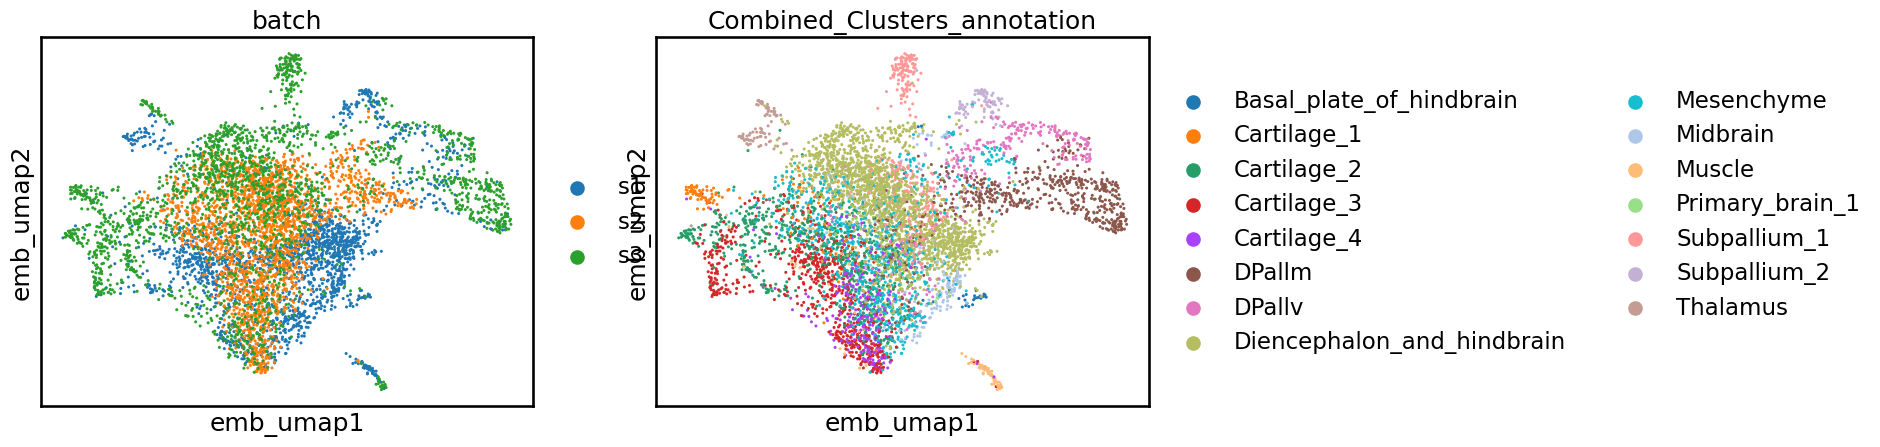

In [9]:
print('Compiling model...')
model.compile(
    lam_data=lam_data, lam_kl=lam_kl, lam_align=lam_align,
    lam_cross=lam_cross, lam_cos=lam_cos, normalize_u=normalize_u,
    domain_weight={"gex": 1, "other": 1}
)

# help(model.fit)
print('Training model...')
model.fit(
    {"gex": gex, "other": other}, max_epochs=max_epochs1,
)
model.save(os.path.join(out_dir, "pretrain.dill"))

# ===============================
#               stage 2
# ===============================

logging.info('Concatenating training and test data...')
input_mod1 = ad.concat(
    {"train": input_train_mod1, "test": input_test_mod1},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod1.uns["feature_type"] = 'GEX'

input_mod2 = ad.concat(
    {"train": input_train_mod2, "test": input_test_mod2},
    axis=0, join="outer", merge="same", label="group",
    fill_value=0, index_unique="-"
)
input_mod2.uns["feature_type"] = 'ATAC'

gex, other = input_mod1, input_mod2

logging.info('Reading preprocessors...')
with open(os.path.join(
       out_dir, "prep.pickle"
), "rb") as f:
    prep = pickle.load(f)
    gex_prep = prep["gex_prep"]
    other_prep = prep["other_prep"]

logging.info('Preprocessing...')
gex_prep.transform(gex)
other_prep.transform(other)

logging.info('Fine-tuning model...')
scglue.models.configure_dataset(
    gex, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca",
    use_batch="batch", use_uid="uid"
)
scglue.models.configure_dataset(
    other, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_lsi",
    use_batch="batch", use_uid="uid"
)

with open(os.path.join(
        out_dir, "hyperparams.yaml"
), "r") as f:
    hyperparams = yaml.load(f, Loader=yaml.Loader)

logging.info('Building model...')
model = scglue.models.SCCLUEModel(
    {"gex": gex, "other": other},
    latent_dim=hyperparams["latent_dim"],
    x2u_h_depth=hyperparams["x2u_h_depth"],
    x2u_h_dim=hyperparams["x2u_h_dim"],
    u2x_h_depth=hyperparams["u2x_h_depth"],
    u2x_h_dim=hyperparams["u2x_h_dim"],
    du_h_depth=hyperparams["du_h_depth"],
    du_h_dim=hyperparams["du_h_dim"],
    dropout=hyperparams["dropout"],
    shared_batches=False,
    random_seed=hyperparams["random_seed"]
)
# print(model.net)

logging.info('Adopting pretrained weights...')
model.adopt_pretrained_model(scglue.models.load_model(os.path.join(
    out_dir, "pretrain.dill"
)))

logging.info('Compiling model...')
model.compile(
    lam_data=hyperparams["lam_data"],
    lam_kl=hyperparams["lam_kl"],
    lam_align=hyperparams["lam_align"],
    lam_cross=hyperparams["lam_cross"],
    lam_cos=hyperparams["lam_cos"],
    normalize_u=hyperparams["normalize_u"],
    domain_weight={"gex": 1, "other": 1},
    lr=1e-3  # TODO: Fine-tuning learning rate
)

logging.info('Training model...')
model.fit(
    {"gex": gex, "other": other},
    align_burnin=0, max_epochs=max_epochs2,
    patience=8, reduce_lr_patience=3
)

logging.info('Projecting cell embeddings...')
gex.obsm["X_model"] = model.encode_data("gex", gex)
other.obsm["X_model"] = model.encode_data("other", other)

input_train_mod1.obsm['emb'] = gex.obsm["X_model"][:input_train_mod1.n_obs]
input_test_mod1.obsm['emb'] = gex.obsm["X_model"][input_train_mod1.n_obs:]

input_train_mod2.obsm['emb'] = other.obsm["X_model"][:input_train_mod2.n_obs]
input_test_mod2.obsm['emb'] = other.obsm["X_model"][input_train_mod2.n_obs:]

ad_train_mean_enc = sc.AnnData(
    (input_train_mod1.obsm['emb'] + input_train_mod2.obsm['emb'])/2, 
    obs=input_train_mod1.obs.copy()
)
ad_train_mean_enc.obsm['emb'] = ad_train_mean_enc.X.copy()
ad_train_mean_enc.obsm['spatial'] = input_train_mod1.obsm['spatial']
ad_mosaic = sc.concat([ad_train_mean_enc, input_test_mod1, input_test_mod2])
ad_mosaic = get_umap(ad_mosaic, ['emb'])

wrap_warn_plot(ad_mosaic, 'emb_umap', ['batch', 'Combined_Clusters_annotation'])
# plt.figure(figsize=(18, 6))
# wrap_warn_plot(ad_train_mean_enc, 'spatial', ['kmeans', 'louvain_k', 'gt'], s=200)
# wrap_warn_plot(input_test_mod1, 'spatial', ['kmeans', 'louvain_k', 'gt'], s=200)
# wrap_warn_plot(input_test_mod2, 'spatial', ['kmeans', 'louvain_k', 'gt'], s=200)


In [10]:
from lisi_bridge import eval_bridge
eval_bridge(
        input_test_mod1, input_test_mod2,
        label_key=None,
        batch_key='Sample',
        use_rep='emb',
        use_fosc=True, use_acc=False, use_score=True,
    )


FOSCTTM=0.25431
Match_score=0.00348


{'FOSCTTM': 0.25430824987021916, 'Match_score': 0.003482429519863255}

### batch corr

In [11]:
from batchCorr import HARMONY

ad_mosaic.obsm['emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['emb']), ad_mosaic.obs['batch'].to_list())
split_ob([ad_train_mean_enc, input_test_mod1, input_test_mod2], ad_mosaic, ob='obsm', key='emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
	Completed 9 / 10 iteration(s).
Reach convergence after 9 iteration(s).


In [12]:
r3 = eval_bridge(
        input_test_mod1, input_test_mod2,
        label_key=None,
        batch_key='Sample',
        use_rep='emb_har',
        use_fosc=True, use_acc=False, use_score=True,
    )

FOSCTTM=0.22618
Match_score=0.00299


## Vis

In [13]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/misar_seq/E15-18-18_modalMatch/clue'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['emb'], index=ad_mosaic.obs_names.to_list())
# df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['emb_har'], index=ad_mosaic.obs_names.to_list())
# df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))